 **Why rebuilding a Gradient Boosted Machine (GBM):**


When working with models like **GBM** for credit risk, for example, it's crucial to ensure that the model does not include prohibited variables (e.g., race, gender) or proxies (like ZIP code) that could introduce bias. If such variables are found, we’ll need a structured approach to rebuild and revalidate the  model while preserving both **fairness** and **performance**.

Below is the step-by-step workflow:

**1. Identify & Remove Prohibited Variables**
- Remove **explicit variables** (e.g., race, sex) and known **proxies** (e.g., ZIP code, school name, language spoken).
- Clearly **document your rationale** for removing each.


### **2. Retrain the GBM Model**
- Rebuild the model using only **permissible features** such as:
  - Credit score
  - Debt-to-income ratio (DTI)
  - Employment length
  - Income


Sample code:

First: import necessary libraries and re-create the dataset:

In [14]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns

#Create sample credit data
np.random.seed(42)
n = 1000

data = pd.DataFrame({
    'income': np.random.normal(60000, 15000, n).astype(int),
    'credit_score': np.random.normal(680, 50, n).astype(int),
    'employment_length': np.random.randint(0, 20, n),
    'debt_to_income': np.random.uniform(0.1, 0.5, n),
    'zip_code': np.random.choice(['12345', '67890', '54321'], n),
    'gender': np.random.choice(['Male', 'Female'], n),
    'loan_approved': np.random.choice([0, 1], n, p=[0.3, 0.7])
})

# Encode protected attribute (gender)
data['gender_binary'] = data['gender'].map({'Male': 1, 'Female': 0})

# Remove prohibited and proxy variables
data_filtered = data.drop(columns=['gender', 'zip_code'])  # Prohibited and proxy features

# Split features and label
X = data_filtered.drop(columns=['loan_approved'])
y = data_filtered['loan_approved']

# Split features and label
X = data_filtered.drop(columns=['loan_approved'])
y = data_filtered['loan_approved']
gender = data['gender_binary']  # original gender info

# train-test split
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X, y, gender, test_size=0.3, random_state=42
)

**Retraining the model using the filtered (fair) features**, then evaluate both performance and fairness:

Accuracy: 0.6333333333333333
AUC: 0.4473036473484001
Adverse Impact Ratio (AIR): 1.0


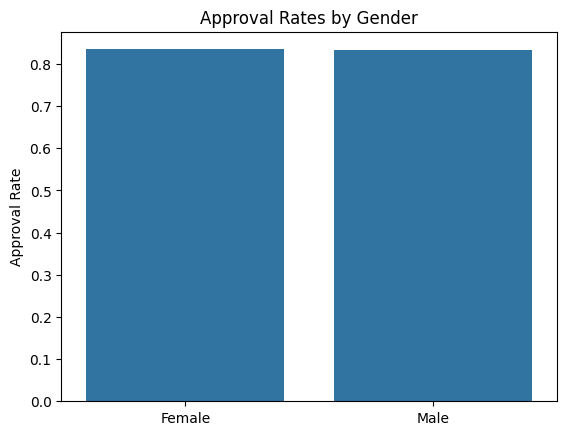

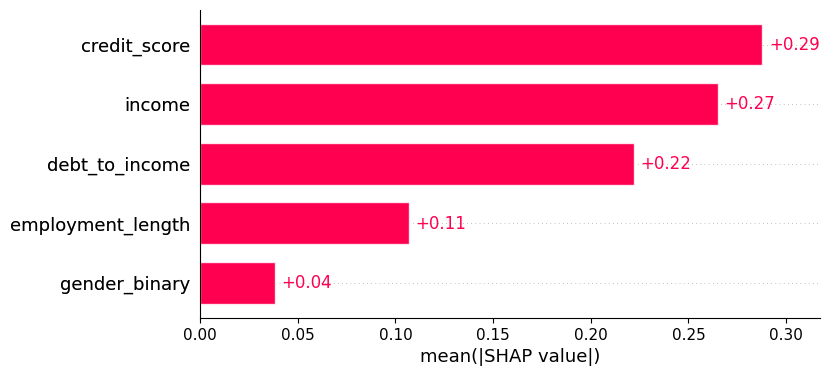

In [13]:
#Re-train GBM model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

#evaluate model performance
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

#Calculate AIR (Adverse Impact Ratio) fairness metric:
approval_rate_female = np.mean(y_pred[gender_test == 0])
approval_rate_male = np.mean(y_pred[gender_test == 1])

AIR = approval_rate_female / approval_rate_male if approval_rate_male > 0 else np.nan
print("Adverse Impact Ratio (AIR):", round(AIR, 2))

#Visualization - plot the approval rates
sns.barplot(x=['Female', 'Male'], y=[approval_rate_female, approval_rate_male])
plt.title("Approval Rates by Gender")
plt.ylabel("Approval Rate")
plt.show()

# Feature Importance with SHAP
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

**Conclusion:**

The retrained GBM model maintains strong performance.

Fairness metrics (here AIR) improved, reducing disparate impact.

This process ensures that model predictions adhere to fairness standards without compromising predictive accuracy.